## Imports

In [1]:
from keras.src.applications import vgg19
from keras import layers, callbacks, utils, metrics, Sequential
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


## Constants

In [2]:
# Constantes
IS_TO_FIND_BEST_HYPERPARAMS = True
IS_TO_TRAIN = True
IS_TO_REPLICATE = True
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

NUM_CLASSES = 1
SEED = 7654321
MAX_EPOCHS = 50

HYPERPARAMS_FILENAME = "models/best_binary_model.hyperparams.json"

In [3]:
BEST_VGG_MODEL_PATH = "models/best_vgg_model.weights.h5"
BEST_MOBILE_MODEL_PATH = "models/best_mobile_model.weights.h5"

BEST_VGG_MODEL_CHECKPOINT = callbacks.ModelCheckpoint(
    filepath=BEST_VGG_MODEL_PATH,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

# callback para parar o treino caso não se verifiquem melhorias na loss
EARLY_STOPPING = callbacks.EarlyStopping(monitor="val_loss", patience=5)

### Dataset load

In [4]:
DATASET_PATH = "../cats_and_dogs"

train_ds = utils.image_dataset_from_directory(
    DATASET_PATH + "/train",
    labels="inferred",
    label_mode="binary",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=SEED,
    batch_size=BATCH_SIZE,
)
val_ds, test_ds = utils.image_dataset_from_directory(
    DATASET_PATH + "/validation",
    labels="inferred",
    label_mode="binary",
    validation_split=0.5,
    subset="both",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=SEED,
    batch_size=BATCH_SIZE,
)

# as labels foram inferidas a partir dos nomes dos diretórios
LABELS = train_ds.class_names
print("Encontradas as classes: ", LABELS)

# carregar os datasets em memória - uma vez carregados, a ordem dos batches já não muda
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Using 500 files for training.
Using 500 files for validation.
Encontradas as classes:  ['cats', 'dogs']


2025-03-28 15:58:59.519752: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-28 15:58:59.519780: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-28 15:58:59.519782: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1743177539.520998  667679 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743177539.521382  667679 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Pre-process dataset

In [5]:
def preprocess_dataset(dataset):
	return dataset.map(lambda x, y: (vgg19.preprocess_input(x), y))

vgg_train_ds = preprocess_dataset(train_ds)
vgg_val_ds = preprocess_dataset(val_ds)
vgg_test_ds = preprocess_dataset(test_ds)

In [6]:
# Load the VGG19 model without the top layer
base_model = vgg19.VGG19(
    weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze the base model
base_model.trainable = False


# Add your own dense layer for binary classification
cat_dog_model = Sequential(
    [
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(.25),
        layers.Dense(1, activation="sigmoid"),
    ], name="vgg19_dog_cat_model"
)

# definição do algoritmo de otimização e da função de perda (loss)
cat_dog_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", metrics.F1Score],
)

# sumário do modelo
cat_dog_model.summary()

/Users/xoutoz/workspace/master/APVC/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "vgg19_dog_cat_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [7]:
history = cat_dog_model.fit(
    vgg_train_ds,
    epochs=MAX_EPOCHS,
    validation_data=vgg_val_ds,
    callbacks=[BEST_VGG_MODEL_CHECKPOINT, EARLY_STOPPING],
)

Epoch 1/50


2025-03-28 15:59:00.321000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 623ms/step - accuracy: 0.7954 - f1_score: 0.7844 - loss: 32.6959 - val_accuracy: 0.9460 - val_f1_score: 0.9405 - val_loss: 15.6117
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 608ms/step - accuracy: 0.9646 - f1_score: 0.9610 - loss: 5.9585 - val_accuracy: 0.9520 - val_f1_score: 0.9563 - val_loss: 12.9994
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 603ms/step - accuracy: 0.9681 - f1_score: 0.9673 - loss: 6.5590 - val_accuracy: 0.9640 - val_f1_score: 0.9691 - val_loss: 7.0940
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 594ms/step - accuracy: 0.9766 - f1_score: 0.9759 - loss: 3.7337 - val_accuracy: 0.9700 - val_f1_score: 0.9677 - val_loss: 4.1220
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 601ms/step - accuracy: 0.9891 - f1_score: 0.9883 - loss: 1.0328 - val_accuracy: 0.9700 - val_f1_score: 0.9683 - val_loss: 3.6834
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 600ms/step - accuracy: 0.9907 - f1_score: 0.9906 - loss: 0.8844 - val_accuracy: 0.9720 - val_f1_score: 0.9703 -

2025-03-28 16:04:10.273889: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step
Falhou em 4 amostras num total de 500 imagens de flores
Test Dataset Metrics:
Taxa de acertos: 99.20 %
Precisão: 98.8142 %
Cobertura: 99.6016 %
F1 Score: 99.2063 %


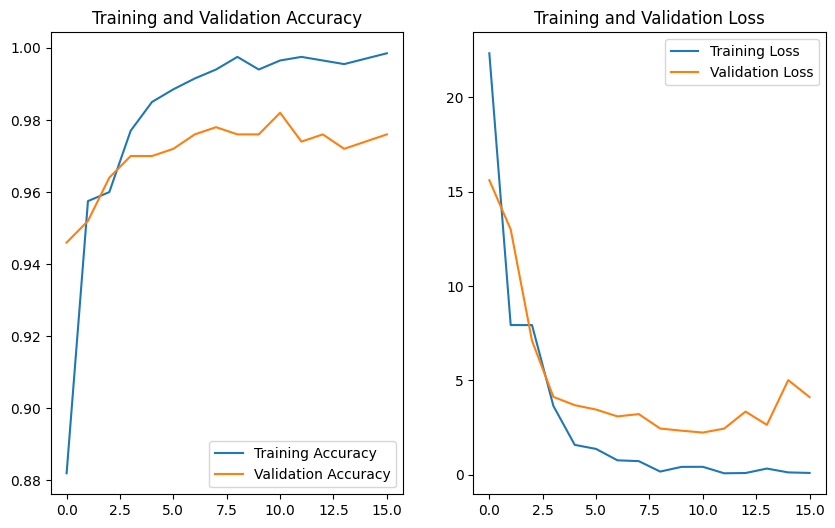

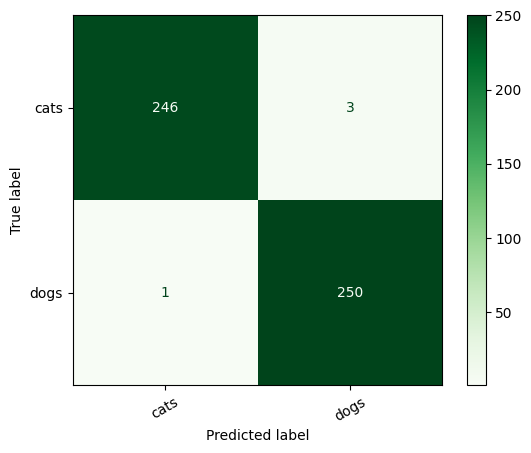

In [ ]:
# carregar o melhor modelo encontrado durante o treino
cat_dog_model.load_weights(BEST_VGG_MODEL_PATH)

# obter as predições e ground thruth num formato mais fácil de tratar
# (vetores com os ids das classes)

y_true = np.concatenate([y.numpy() for x, y in vgg_test_ds], axis=0)

# Make predictions
output_pred = cat_dog_model.predict(vgg_test_ds)
y_pred = (output_pred > 0.5).astype(int).flatten()  # Convert sigmoid output to 0 or 1

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

n_misses = np.count_nonzero(y_pred != y_true.flatten())
n_preds = y_pred.shape[0]
accuracy = (n_preds - n_misses) / n_preds

print(
    "Falhou em {:d} amostras num total de {:d} imagens de flores".format(
        n_misses, n_preds
    )
)

# Calculate precision, recall, and F1 score
test_precision = precision_score(y_true, y_pred)
test_recall = recall_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print(f"Test Dataset Metrics:")
print("Taxa de acertos: {:.2f} %".format(accuracy * 100))
print(f"Precisão: {test_precision * 100:.4f} %")
print(f"Cobertura: {test_recall * 100:.4f} %")
print(f"F1 Score: {test_f1 * 100:.4f} %")


# gerar gráficos e matriz de confusão
cm = confusion_matrix(y_true, y_pred)

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(len(acc))

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap="Greens", xticks_rotation=30)
plt.show()

2025-03-28 16:04:33.824970: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


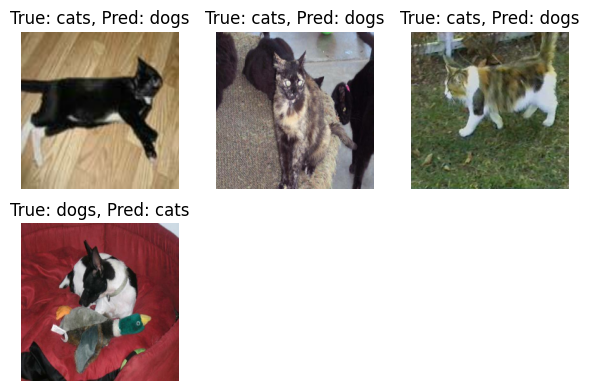

In [9]:
# Collect misclassified images and their labels
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

for images, labels in test_ds.unbatch():
    # Preprocess the images using vgg19.preprocess_input
    preprocessed_images = vgg19.preprocess_input(np.expand_dims(images.numpy(), axis=0))
    predictions = cat_dog_model.predict(preprocessed_images, verbose=0)
    predicted_label = int(predictions[0, 0] > 0.5)
    true_label = int(labels.numpy().item())

    if predicted_label != true_label:
        misclassified_images.append(images.numpy().astype("uint8"))
        misclassified_labels.append(true_label)
        misclassified_predictions.append(predicted_label)

plt.figure(figsize=(6, 4))
for i in range(len(misclassified_images)):
    plt.subplot(len(misclassified_images) // 3 + 1, 3, i + 1)
    plt.imshow(misclassified_images[i])
    plt.title(f"True: {LABELS[misclassified_labels[i]]}, Pred: {LABELS[misclassified_predictions[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
# Load custom dataset
CUSTOM_DATASET_PATH = "../custom_dataset"

custom_ds = utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    labels="inferred",
    label_mode="binary",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,  # Load one image at a time for display
)

Found 9 files belonging to 2 classes.


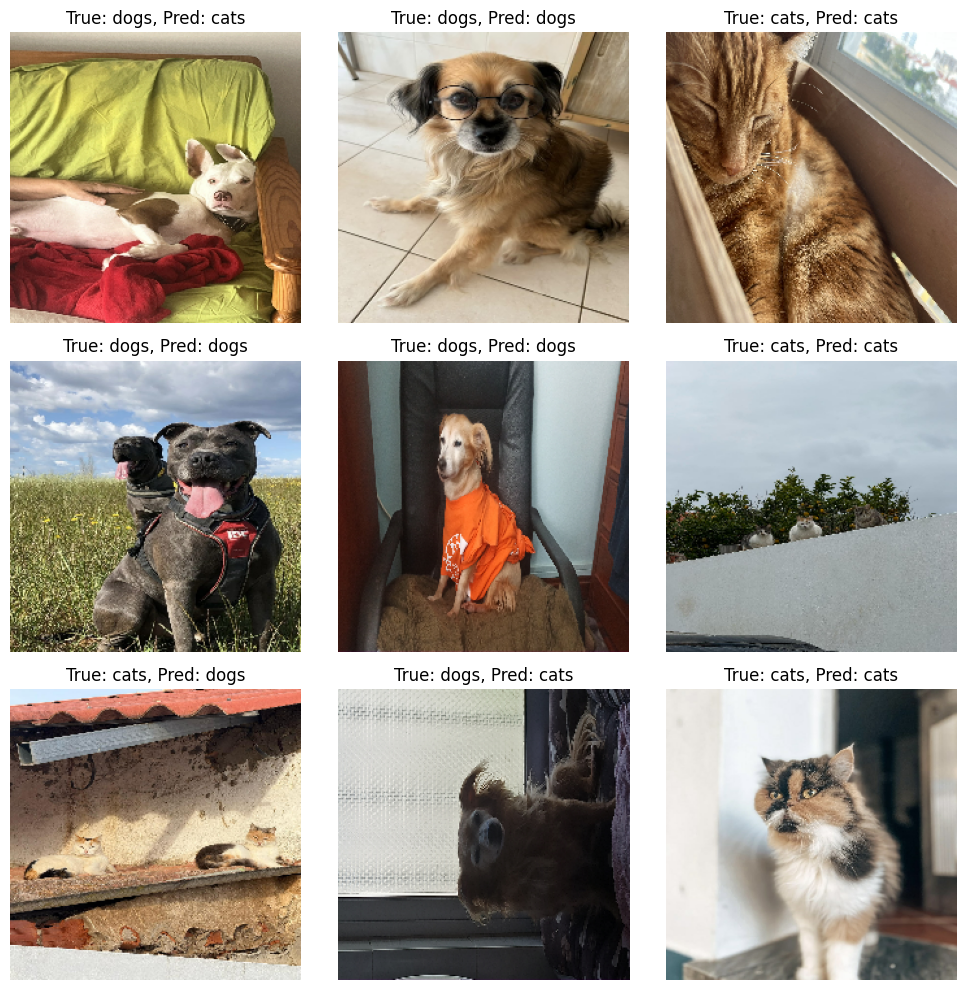

In [11]:
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(custom_ds.unbatch()):  # Display up to 9 images
    preprocessed_images = vgg19.preprocess_input(np.expand_dims(images.numpy(), axis=0))
    predictions = cat_dog_model.predict(preprocessed_images, verbose=0)
    predicted_label = int(predictions[0, 0] > 0.5)
    true_label = int(labels.numpy().item())

    plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(f"True: {LABELS[true_label]}, Pred: {LABELS[predicted_label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [12]:
# Collect true labels and predictions for the custom dataset
custom_y_true = []
custom_y_pred = []

for images, labels in custom_ds.unbatch():
    preprocessed_images = vgg19.preprocess_input(np.expand_dims(images.numpy(), axis=0))
    predictions = cat_dog_model.predict(preprocessed_images, verbose=0)
    predicted_label = int(predictions[0, 0] > 0.5)
    true_label = int(labels.numpy().item())

    custom_y_true.append(true_label)
    custom_y_pred.append(predicted_label)

# Calculate metrics
custom_accuracy = accuracy_score(custom_y_true, custom_y_pred)
custom_precision = precision_score(custom_y_true, custom_y_pred)
custom_recall = recall_score(custom_y_true, custom_y_pred)
custom_f1 = f1_score(custom_y_true, custom_y_pred)

print(f"Custom Dataset Metrics:")
print(f"Accuracy: {custom_accuracy * 100:.4f} %")
print(f"Precision: {custom_precision * 100:.4f} %")
print(f"Recall: {custom_recall * 100:.4f} %")
print(f"F1 Score: {custom_f1 * 100:.4f} %")

Custom Dataset Metrics:
Accuracy: 66.6667 %
Precision: 75.0000 %
Recall: 60.0000 %
F1 Score: 66.6667 %


2025-03-28 16:04:35.023428: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
